# Question for finding the 'Discharge Pressure (psig)'

# Importing all necessary Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
import xgboost
import pickle
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.simplefilter('ignore')

# Data Preprocessing

In [2]:
data=pd.read_csv("Expander_data.csv")

In [3]:
data.head()

,Timestamp,Suction Pressure (psig),Suction Temperature (F),Total Flow (gpm),Speed (rpm),By-pass Valve Position (%),Discharge Pressure (psig),Discharge Temperature (F),Run Status
0,04-01-2020 21:20,596.100853,-229.436683,7925.800487,2999.411045,6.0,226.044931,-227.614448,NaN
1,04-01-2020 21:20,596.838217,-230.453708,8085.917724,2989.706617,6.0,217.150974,-228.668636,NaN
2,04-01-2020 21:20,596.468895,-229.545356,7902.175243,3006.331679,6.0,226.054086,-227.755324,NaN
3,04-01-2020 21:20,603.568271,-230.309438,7991.808959,3010.487486,6.0,226.016182,-228.489113,NaN
4,04-01-2020 21:21,595.407372,-229.767969,7871.560747,2986.665518,6.0,227.769383,-227.971795,NaN


In [4]:
data.columns

Index(['Timestamp', 'Suction Pressure (psig)', 'Suction Temperature (F)',
       'Total Flow (gpm)', 'Speed (rpm)', 'By-pass Valve Position (%)',
       'Discharge Pressure (psig)', 'Discharge Temperature (F)', 'Run Status'],
      dtype='object')

In [5]:
data.drop("Timestamp",axis=1,inplace=True)

In [6]:
data.shape

(296450, 8)

In [7]:
data['Run Status'].isnull().sum() #all values in run status is null so we can drop this columns it is  not give any information to us

296450

In [8]:
data.drop("Run Status",axis=1,inplace=True)

# Visualizing the range of discharge pressure in patient

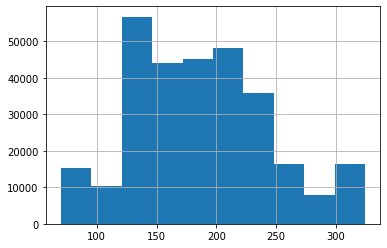

In [9]:
data['Discharge Pressure (psig)'].hist()
plt.show()

# Feature Engineering

# Correlation between features

In [10]:
data_corr=data.corr()

In [11]:
data_corr["Discharge Pressure (psig)"] #here we can see that suction pressure (psig) , Suction Temperature (F),Discharge Temperature
#(f) are most correlated to the discharge pressure.

Suction Pressure (psig)       0.905435
Suction Temperature (F)       0.960071
Total Flow (gpm)             -0.973483
Speed (rpm)                  -0.434955
By-pass Valve Position (%)    0.400566
Discharge Pressure (psig)     1.000000
Discharge Temperature (F)     0.960065
Name: Discharge Pressure (psig), dtype: float64

In [12]:
data.isnull().sum() # so we have no null values 

Suction Pressure (psig)       0
Suction Temperature (F)       0
Total Flow (gpm)              0
Speed (rpm)                   0
By-pass Valve Position (%)    0
Discharge Pressure (psig)     0
Discharge Temperature (F)     0
dtype: int64

In [13]:
#Normalizing our data using standard scalar

# Standard Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
X=data.iloc[:,[0,1,2,3,4,6]]

In [16]:
y=data.iloc[:,[5]]

In [17]:
std_converter=StandardScaler()

In [18]:
X=std_converter.fit_transform(X)

In [19]:
Scaled_X=pd.DataFrame(X,columns=['Suction Pressure (psig)', 'Suction Temperature (F)',
                        'Total Flow (gpm)', 'Speed (rpm)', 'By-pass Valve Position (%)','Discharge Temperature (F)'])

In [20]:
Scaled_y=std_converter.fit_transform(y)

In [21]:
X_train,X_test,y_train,y_test=train_test_split(Scaled_X,Scaled_y,test_size=.2,random_state=2)

In [22]:
len(X_train)

237160

In [22]:
#selection of best machine learning model 

# Finding best model using cross validation 

In [47]:
scores={}
model_names=['Linear_regression','random_forest_regressor','xgboost_regressor','gradientboost_regressor','adaboost_regressor']
model=[linear_model.LinearRegression(),ensemble.RandomForestRegressor(n_estimators=20,max_depth=8),
       xgboost.XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=20,),
       ensemble.GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=20,max_depth=3),
       ensemble.AdaBoostRegressor(n_estimators=20,learning_rate=1.0)]

In [57]:
for i in range(len(model_names)):
    scores[model_names[i]]=cross_val_score(model[i],X_train,y_train,cv=3)

[19:34:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
scores

{'Linear_regression': array([0.99808341, 0.99808799, 0.99810095]),
 'random_forest_regressor': array([0.99786996, 0.99773244, 0.99785354]),
 'xgboost_regressor': array([0.97058635, 0.97023578, 0.97072039]),
 'gradientboost_regressor': array([0.97429744, 0.97386691, 0.97441452]),
 'adaboost_regressor': array([0.97975191, 0.98072108, 0.98221825])}

In [75]:
best_model={}
pre_score=0 # for checking previous score of the model

# Best model score

In [76]:
for i in range(len(model_names)):
    avg_score=sum(scores[model_names[i]])/len(scores[model_names[i]]) #finding the average score of all models
    if avg_score > pre_score:
        best_model[model_names[i]]=avg_score
        pre_score=avg_score
        print(avg_score)

0.9980907840342302


# Best model with score and name

In [77]:
best_model #so here we see that linear regression is the best model with accuracy of 99.80

{'Linear_regression': 0.9980907840342302}

# Fitting the  model

In [23]:
model=linear_model.LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
model.score(X_test,y_test)

0.9980822115255963

In [26]:
pickle.dump(model,open('assignmentquestion1.pkl','wb'))

In [ ]:
chek=pickle.load(open('assignmentquestion1.pkl'))

In [80]:
predicted_value=model.predict(X_test)

In [85]:
value_mean_sqr_err=metrics.mean_squared_error(y_test, predicted_value)#mean sqaure error

# RMSE

In [86]:
import math
rmse=math.sqrt(value_mean_sqr_err) #calculating the root mean squared error

In [92]:
print(value_mean_sqr_err)
print(rmse)

0.0019206560004083207
0.04382528950741022


# Method for converting the output back into original form

In [145]:
def original(x):
    x=np.array(x).reshape(-1,1)
    return st.inverse_transform(x) #this method will convert the ouput back into original form

# Please normalize the data before testing using standardscaler

In [124]:
st=StandardScaler() 
def standarscaler(x): #this function can we used for conversion 
    x=np.array(x).reshape(-1,1) #converting list into array into (n rows,1) form
    return st.fit_transform(x)#returns normalize value

# Working demo of the standardscaler and original method.

In [146]:
l=[11,12,14]
final=standarscaler(l)

In [147]:
final

array([[-1.06904497],
       [-0.26726124],
       [ 1.33630621]])

In [148]:
new=original(final)

In [149]:
new

array([[11.],
       [12.],
       [14.]])